In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import descwl
import galsim
import argparse
import time

# Timing of Multi Object Fitter (MOF) for a single galaxy as a function of SNR, size, etc

We set up some things before the analysis

In [9]:
parser = argparse.ArgumentParser()

In [10]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
analysis_group = parser.add_argument_group('Analysis options',
    'Specify analysis options')
descwl.analysis.OverlapAnalyzer.add_args(analysis_group)
survey_group = parser.add_argument_group('Survey parameters',
    'Specify survey camera and observing parameters.')
descwl.survey.Survey.add_args(survey_group)
render_group = parser.add_argument_group('Model rendering options',
    'Specify options for rendering models as simulated survey observations.')
descwl.render.Engine.add_args(render_group)

In [11]:
model_group = parser.add_argument_group('Source model options',
    'Specify options for building source models from catalog parameters.')
descwl.model.GalaxyBuilder.add_args(model_group)

In [12]:
survey_name = 'LSST'
filter_band = 'r'

In [13]:
args = parser.parse_args(['--survey-name',survey_name,'--filter-band',filter_band])

We create a `Survey` object from the arguments that we provided before

In [14]:
survey = descwl.survey.Survey.from_args(args)

The class `OverlapAnalyzer` contains the method to do the multi-object-fit. We initialize it.
The arguments are:
* Survey: Survey object; the options are LSST, DES, HSC or CFHTLS.
* `no_hsm`: This option disables the HSM fitting.
* `no_lmfit`: This option disables lmfit.
* `add_noise`: If True it adds noise to the image
* `alpha`: Fraction of flux given to the other object. Values range from -1 (overlapping flux to faintest source) to +1 (overlapping flux to brightest source). The default is +1

In [15]:
analyzer = descwl.analysis.OverlapAnalyzer(survey,no_hsm=True,no_lmfit=False,add_noise=False)

We need to generate a render engine to generate the GalSim stamps 

In [16]:
render_engine = descwl.render.Engine(survey,0.05,30,False,False)

Let's define a function that renders and fits one galaxy

In [27]:
def time_one_galaxy(identifier, redshift, ab_magnitude, ri_color, cosmic_shear_g1, cosmic_shear_g2, 
               dx_arcsecs, dy_arcsecs, beta_radians, disk_frac, disk_hlr_arcsecs, 
               disk_q, bulge_frac, bulge_hlr_arcsecs, bulge_q, verbose=False,ftol=1e-2, add_noise=False):
    dtype=[
            ('db_id',np.int64),
            ('grp_id',np.int64),
            ('grp_size',np.int16),
            ('grp_rank',np.int16),
            ('visible',np.int16),
            # Stamp bounding box.
            ('xmin',np.int32),
            ('xmax',np.int32),
            ('ymin',np.int32),
            ('ymax',np.int32),
            # Source properties.
            ('f_disk', np.float32),
            ('f_bulge', np.float32),
            ('dx',np.float32),
            ('dy',np.float32),
            ('z',np.float32),
            ('ab_mag',np.float32),
            ('ri_color',np.float32),
            ('flux',np.float32),
            ('sigma_m',np.float32),
            ('sigma_p',np.float32),
            ('e1',np.float32),
            ('e2',np.float32),
            ('a',np.float32),
            ('b',np.float32),
            ('beta',np.float32),
            ('psf_sigm',np.float32),
            # Pixel-level properties.
            ('purity',np.float32),
            ('snr_sky',np.float32),
            ('snr_iso',np.float32),
            ('snr_grp',np.float32),
            ('snr_isof',np.float32),
            ('snr_grpf',np.float32),
            ('ds',np.float32),
            ('dg1',np.float32),
            ('dg2',np.float32),
            ('ds_grp',np.float32),
            ('dg1_grp',np.float32),
            ('dg2_grp',np.float32),
            # HSM analysis results.
            ('hsm_sigm',np.float32),
            ('hsm_e1',np.float32),
            ('hsm_e2',np.float32),
            # Systematics fit results.
            ('g1_fit',np.float32),
            ('g2_fit',np.float32),
            ]
    data = np.empty(1, dtype=dtype)
    table = astropy.table.Table(data,copy = False)
    t0 = time.time()
    total_flux = survey.get_flux(ab_magnitude)
    disk_flux = disk_frac*total_flux
    bulge_flux = bulge_frac*total_flux
    agn_frac = 1. - disk_frac - bulge_frac
    if agn_frac<0:
        print agn_frac,bulge_frac,disk_frac,'The disk, bulge and AGN fractions have to add up to 1'
    agn_flux = agn_frac*total_flux
    galaxy = descwl.model.Galaxy(identifier, redshift, ab_magnitude, ri_color, cosmic_shear_g1, cosmic_shear_g2, 
               dx_arcsecs, dy_arcsecs, beta_radians, disk_flux, disk_hlr_arcsecs, 
               disk_q, bulge_flux, bulge_hlr_arcsecs, bulge_q, agn_flux)
    t1 = time.time()
    stamps,bounds = render_engine.render_galaxy(galaxy,True,False)
    t2 = time.time()
    analyzer = descwl.analysis.OverlapAnalyzer(survey,no_hsm=True,no_lmfit=False,add_noise=False)
    analyzer.add_galaxy(galaxy,stamps,bounds)
    results = descwl.analysis.OverlapResults(survey,table,[stamps],[bounds],21)
    gal_stamp = results.get_stamp(identifier)
    npix = gal_stamp.array.shape[0]*gal_stamp.array.shape[1]
    if add_noise:
        generator = galsim.random.BaseDeviate(seed = 1)
        noise = galsim.PoissonNoise(rng = generator, sky_level = survey.mean_sky_level)
        gal_stamp.addNoise(noise)
    if verbose:
        print gal_stamp
    t3 = time.time()
    res = analyzer.fit_galaxies([identifier],gal_stamp,ftol=ftol)
    minimum = analyzer.minimum
    t4 = time.time()
    if verbose:
        print 'Time to generate the galaxy: ', t1-t0, ' s'
        print 'Time to render the galaxy: ', t2-t1, ' s'
        print 'Time to add the galaxy to the stamp: ', t3-t2, ' s'
        print 'Time to fit the galaxy ', t4-t3, ' s'
    return t4-t3, npix, minimum.redchi

In [62]:
%timeit dt, npix, redchi = time_one_galaxy(0,0,22,0,0,0,0,0,0,1,1.,1,0,0,0)

10 loops, best of 3: 33.9 ms per loop


In [63]:
%timeit dt, npix, redchi =time_one_galaxy(0,0,19,0,0,0,0,0,0,1.,1.,1,0,0,0)

10 loops, best of 3: 32.9 ms per loop


In [64]:
%timeit dt, npix, redchi =time_one_galaxy(0,0,19,0,0,0,0,0,0,1.,1.,1,0,0,0,add_noise=True)

10 loops, best of 3: 33.6 ms per loop


## Magnitude dependence

In [42]:
npoints = 100
t_disk = np.zeros(npoints)
t_bulge = np.zeros(npoints)
t_agn = np.zeros(npoints)
s_disk = np.zeros(npoints)
s_bulge = np.zeros(npoints)
s_agn = np.zeros(npoints)
rchi_disk = np.zeros(npoints)
rchi_bulge = np.zeros(npoints)
rchi_agn = np.zeros(npoints)
mag_min=15.
mag_max=28.5
mags_array = np.linspace(mag_min,mag_max,npoints)
sigma_m = 0.2 #typical size of LSST galaxies in arcseconds
for i, mag in enumerate(mags_array):
    t_disk[i], s_disk[i], rchi_disk[i] = time_one_galaxy(0,0,mag,0,0,0,0,0,0,1.,sigma_m,1.,0,0,0)
    t_bulge[i], s_bulge[i], rchi_bulge[i] = time_one_galaxy(0,0,mag,0,0,0,0,0,0,0,0,0,1,sigma_m,1)
    t_agn[i], s_agn[i], rchi_agn[i] = time_one_galaxy(0,0,mag,0,0,0,0,0,0,0,0,0,0,0,0)

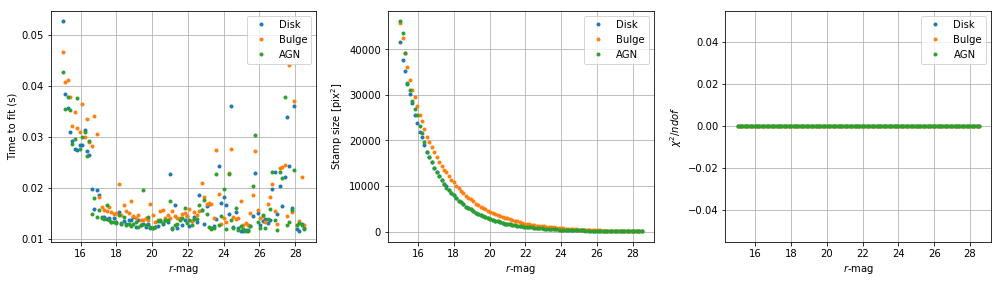

In [43]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(mags_array,t_disk,'.',label='Disk')
ax[1].plot(mags_array,s_disk,'.',label='Disk')
ax[0].plot(mags_array,t_bulge,'.',label='Bulge')
ax[1].plot(mags_array,s_bulge,'.',label='Bulge')
ax[0].plot(mags_array,t_agn,'.',label='AGN')
ax[1].plot(mags_array,s_agn,'.',label='AGN')
ax[0].set_xlabel('$r$-mag')
ax[0].set_ylabel('Time to fit (s)')
ax[0].legend(loc='best')
ax[0].grid()
ax[1].set_xlabel('$r$-mag')
ax[1].set_ylabel('Stamp size [pix$^{2}$]')
ax[1].grid()
ax[1].legend(loc='best')
ax[2].plot(mags_array,rchi_disk,'.',label='Disk')
ax[2].plot(mags_array,rchi_bulge,'.',label='Bulge')
ax[2].plot(mags_array,rchi_agn,'.',label='AGN')
ax[2].set_xlabel('$r$-mag')
ax[2].set_ylabel(r'$\chi^{2}/ndof$')
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()

# Magnitude dependence with noise

In [44]:
npoints = 100
t_disk = np.zeros(npoints)
t_bulge = np.zeros(npoints)
t_agn = np.zeros(npoints)
s_disk = np.zeros(npoints)
s_bulge = np.zeros(npoints)
s_agn = np.zeros(npoints)
rchi_disk = np.zeros(npoints)
rchi_bulge = np.zeros(npoints)
rchi_agn = np.zeros(npoints)
mag_min=15.
mag_max=28.5
mags_array = np.linspace(mag_min,mag_max,npoints)
sigma_m = 0.2 #typical size of LSST galaxies in arcseconds
for i, mag in enumerate(mags_array):
    t_disk[i], s_disk[i], rchi_disk[i] = time_one_galaxy(0,0,mag,0,0,0,0,0,0,1.,sigma_m,1.,0,0,0,add_noise=True)
    t_bulge[i], s_bulge[i], rchi_bulge[i] = time_one_galaxy(0,0,mag,0,0,0,0,0,0,0,0,0,1,sigma_m,1,add_noise=True)
    t_agn[i], s_agn[i], rchi_agn[i] = time_one_galaxy(0,0,mag,0,0,0,0,0,0,0,0,0,0,0,0,add_noise=True)

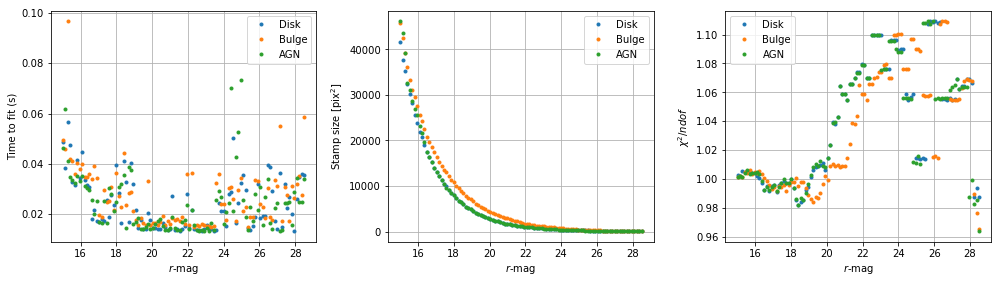

In [45]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(mags_array,t_disk,'.',label='Disk')
ax[1].plot(mags_array,s_disk,'.',label='Disk')
ax[0].plot(mags_array,t_bulge,'.',label='Bulge')
ax[1].plot(mags_array,s_bulge,'.',label='Bulge')
ax[0].plot(mags_array,t_agn,'.',label='AGN')
ax[1].plot(mags_array,s_agn,'.',label='AGN')
ax[0].set_xlabel('$r$-mag')
ax[0].set_ylabel('Time to fit (s)')
ax[0].legend(loc='best')
ax[0].grid()
ax[1].set_xlabel('$r$-mag')
ax[1].set_ylabel('Stamp size [pix$^{2}$]')
ax[1].grid()
ax[1].legend(loc='best')
ax[2].plot(mags_array,rchi_disk,'.',label='Disk')
ax[2].plot(mags_array,rchi_bulge,'.',label='Bulge')
ax[2].plot(mags_array,rchi_agn,'.',label='AGN')
ax[2].set_xlabel('$r$-mag')
ax[2].set_ylabel(r'$\chi^{2}/ndof$')
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()

## Size dependence

In [46]:
npoints = 100
size_min=0.01
size_max=1.5
size = np.linspace(size_min,size_max,npoints)
for i in range(npoints):
    t_disk[i], s_disk[i], rchi_disk[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,1.,size[i],1.,0,0,0)
    t_bulge[i], s_bulge[i], rchi_bulge[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,1,size[i],1)
    t_agn[i], s_agn[i], rchi_agn[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,0,0,0)

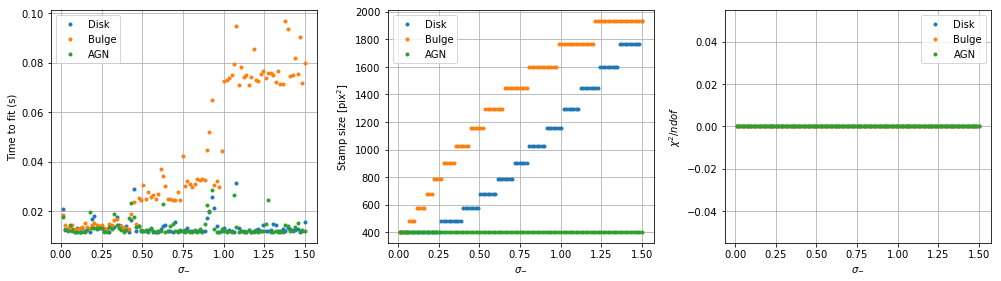

In [50]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(size,t_disk,'.',label='Disk')
ax[1].plot(size,s_disk,'.',label='Disk')
ax[0].plot(size,t_bulge,'.',label='Bulge')
ax[1].plot(size,s_bulge,'.',label='Bulge')
ax[0].plot(size,t_agn,'.',label='AGN')
ax[1].plot(size,s_agn,'.',label='AGN')
ax[0].set_xlabel(r'$\sigma_{-}$')
ax[0].set_ylabel('Time to fit (s)')
ax[0].legend(loc='best')
ax[0].grid()
ax[1].set_xlabel(r'$\sigma_{-}$')
ax[1].set_ylabel('Stamp size [pix$^{2}$]')
ax[1].grid()
ax[1].legend(loc='best')
ax[2].plot(size,rchi_disk,'.',label='Disk')
ax[2].plot(size,rchi_bulge,'.',label='Bulge')
ax[2].plot(size,rchi_agn,'.',label='AGN')
ax[2].set_xlabel(r'$\sigma_{-}$')
ax[2].set_ylabel(r'$\chi^{2}/ndof$')
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()

# Size dependence (with noise)

In [51]:
npoints = 100
size_min=0.01
size_max=1.5
size = np.linspace(size_min,size_max,npoints)
for i in range(npoints):
    t_disk[i], s_disk[i], rchi_disk[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,1.,size[i],1.,0,0,0,add_noise=True)
    t_bulge[i], s_bulge[i], rchi_bulge[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,1,size[i],1,add_noise=True)
    t_agn[i], s_agn[i], rchi_agn[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,add_noise=True)

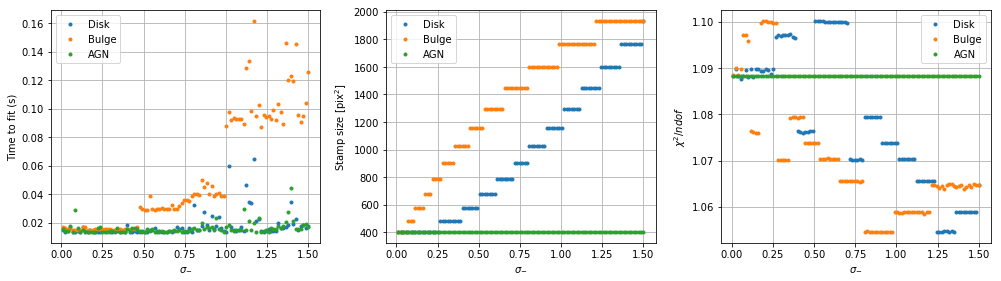

In [52]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(size,t_disk,'.',label='Disk')
ax[1].plot(size,s_disk,'.',label='Disk')
ax[0].plot(size,t_bulge,'.',label='Bulge')
ax[1].plot(size,s_bulge,'.',label='Bulge')
ax[0].plot(size,t_agn,'.',label='AGN')
ax[1].plot(size,s_agn,'.',label='AGN')
ax[0].set_xlabel(r'$\sigma_{-}$')
ax[0].set_ylabel('Time to fit (s)')
ax[0].legend(loc='best')
ax[0].grid()
ax[1].set_xlabel(r'$\sigma_{-}$')
ax[1].set_ylabel('Stamp size [pix$^{2}$]')
ax[1].grid()
ax[1].legend(loc='best')
ax[2].plot(size,rchi_disk,'.',label='Disk')
ax[2].plot(size,rchi_bulge,'.',label='Bulge')
ax[2].plot(size,rchi_agn,'.',label='AGN')
ax[2].set_xlabel(r'$\sigma_{-}$')
ax[2].set_ylabel(r'$\chi^{2}/ndof$')
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()

# Shape dependence

In [53]:
npoints = 100
q_min=0.01
q_max=1.
q = np.linspace(q_min,q_max,npoints)
for i in range(npoints):
    t_disk[i], s_disk[i], rchi_disk[i] = time_one_galaxy(0,0,24,0,0,0,0,0,0,1.,sigma_m,q[i],0,0,0)
    t_bulge[i], s_bulge[i], rchi_bulge[i] = time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,1,sigma_m,q[i])
    t_agn[i], s_agn[i], rchi_agn[i] = time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,0,0,0)

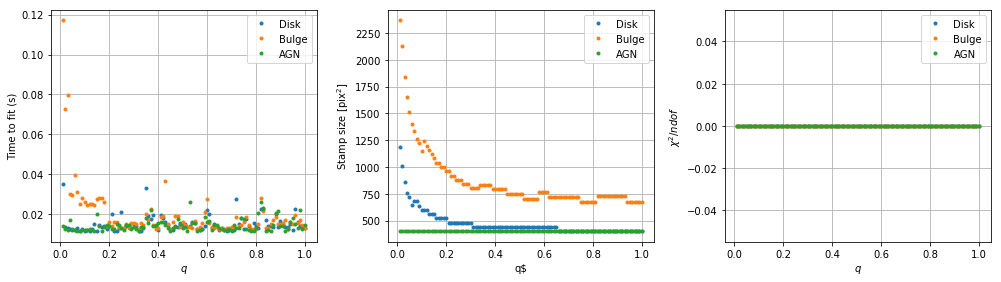

In [54]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(q,t_disk,'.',label='Disk')
ax[1].plot(q,s_disk,'.',label='Disk')
ax[0].plot(q,t_bulge,'.',label='Bulge')
ax[1].plot(q,s_bulge,'.',label='Bulge')
ax[0].plot(q,t_agn,'.',label='AGN')
ax[1].plot(q,s_agn,'.',label='AGN')
ax[0].set_xlabel(r'$q$')
ax[0].set_ylabel('Time to fit (s)')
ax[0].legend(loc='best')
ax[0].grid()
ax[1].set_xlabel(r'q$')
ax[1].set_ylabel('Stamp size [pix$^{2}$]')
ax[1].grid()
ax[1].legend(loc='best')
ax[2].plot(q,rchi_disk,'.',label='Disk')
ax[2].plot(q,rchi_bulge,'.',label='Bulge')
ax[2].plot(q,rchi_agn,'.',label='AGN')
ax[2].set_xlabel(r'$q$')
ax[2].set_ylabel(r'$\chi^{2}/ndof$')
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()

# Shape dependence (with noise)

In [55]:
npoints = 100
q_min=0.01
q_max=1.
q = np.linspace(q_min,q_max,npoints)
for i in range(npoints):
    t_disk[i], s_disk[i], rchi_disk[i] = time_one_galaxy(0,0,24,0,0,0,0,0,0,1.,sigma_m,q[i],0,0,0,add_noise=True)
    t_bulge[i], s_bulge[i], rchi_bulge[i] = time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,1,sigma_m,q[i],add_noise=True)
    t_agn[i], s_agn[i], rchi_agn[i] = time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,add_noise=True)

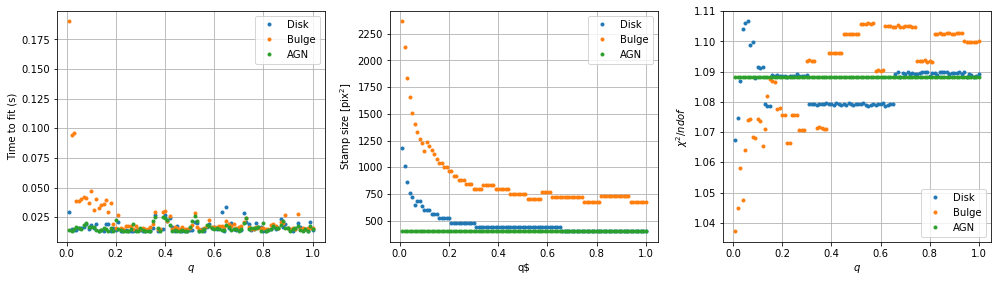

In [56]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(q,t_disk,'.',label='Disk')
ax[1].plot(q,s_disk,'.',label='Disk')
ax[0].plot(q,t_bulge,'.',label='Bulge')
ax[1].plot(q,s_bulge,'.',label='Bulge')
ax[0].plot(q,t_agn,'.',label='AGN')
ax[1].plot(q,s_agn,'.',label='AGN')
ax[0].set_xlabel(r'$q$')
ax[0].set_ylabel('Time to fit (s)')
ax[0].legend(loc='best')
ax[0].grid()
ax[1].set_xlabel(r'q$')
ax[1].set_ylabel('Stamp size [pix$^{2}$]')
ax[1].grid()
ax[1].legend(loc='best')
ax[2].plot(q,rchi_disk,'.',label='Disk')
ax[2].plot(q,rchi_bulge,'.',label='Bulge')
ax[2].plot(q,rchi_agn,'.',label='AGN')
ax[2].set_xlabel(r'$q$')
ax[2].set_ylabel(r'$\chi^{2}/ndof$')
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()

# Orientation dependence

In [57]:
npoints = 100
t_disk = np.zeros(npoints)
t_bulge = np.zeros(npoints)
t_agn = np.zeros(npoints)
beta_min=-np.pi
beta_max=np.pi
beta = np.linspace(beta_min,beta_max,npoints)
for i in range(npoints):
    t_disk[i], s_disk[i], rchi_disk[i]=time_one_galaxy(0,0,24,0,0,0,0,0,beta[i],1.,1.,1,0,0,0)
    t_bulge[i], s_bulge[i], rchi_bulge[i]=time_one_galaxy(0,0,24,0,0,0,0,0,beta[i],0,0,0,1,1.,1)
    t_agn[i], s_agn[i], rchi_agn[i]=time_one_galaxy(0,0,24,0,0,0,0,0,beta[i],0,0,0,0,0,0)

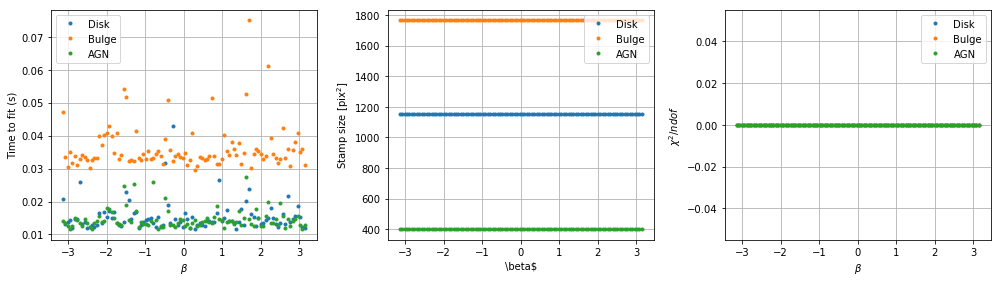

In [58]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(beta,t_disk,'.',label='Disk')
ax[1].plot(beta,s_disk,'.',label='Disk')
ax[0].plot(beta,t_bulge,'.',label='Bulge')
ax[1].plot(beta,s_bulge,'.',label='Bulge')
ax[0].plot(beta,t_agn,'.',label='AGN')
ax[1].plot(beta,s_agn,'.',label='AGN')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Time to fit (s)')
ax[0].legend(loc='best')
ax[0].grid()
ax[1].set_xlabel(r'\beta$')
ax[1].set_ylabel('Stamp size [pix$^{2}$]')
ax[1].grid()
ax[1].legend(loc='best')
ax[2].plot(beta,rchi_disk,'.',label='Disk')
ax[2].plot(beta,rchi_bulge,'.',label='Bulge')
ax[2].plot(beta,rchi_agn,'.',label='AGN')
ax[2].set_xlabel(r'$\beta$')
ax[2].set_ylabel(r'$\chi^{2}/ndof$')
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()

# Component dependence

In [59]:
npoints = 100
t_disk = np.zeros(npoints)
t_bulge = np.zeros(npoints)
t_agn = np.zeros(npoints)
frac_disk = np.random.random(size=npoints)
frac_bulge = np.random.random(size=npoints)
total_frac = frac_disk+frac_bulge
mask = total_frac>1.
frac_disk[mask]=1.-frac_bulge[mask]
total_frac = frac_disk+frac_bulge
print np.where(total_frac>1)
for i in range(npoints):
    t_disk[i], s_disk[i], rchi_disk[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,frac_disk[i],1.,1,frac_bulge[i],1.,1.)
    t_bulge[i], s_bulge[i], rchi_bulge[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,frac_disk[i],1.,1.,0,0,0)
    t_agn[i], s_agn[i], rchi_agn[i]=time_one_galaxy(0,0,24,0,0,0,0,0,0,0,0,0,frac_bulge[i],1.,1.)

(array([], dtype=int64),)


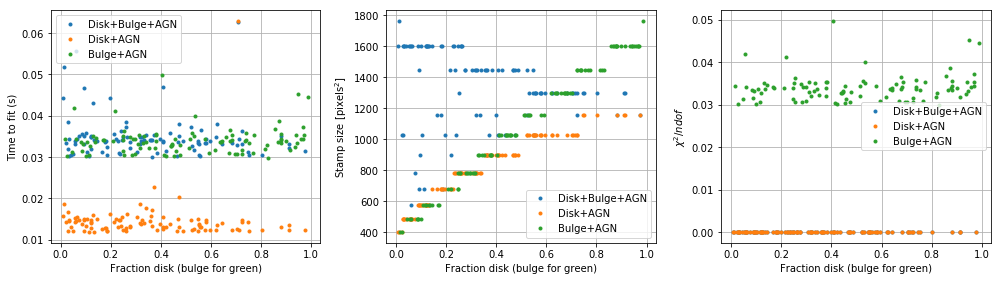

In [61]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(np.sort(frac_disk),t_disk[np.argsort(frac_disk)],'.',label='Disk+Bulge+AGN')
ax[0].plot(np.sort(frac_disk),t_bulge[np.argsort(frac_disk)],'.',label='Disk+AGN')
ax[0].plot(np.sort(frac_bulge),t_agn[np.argsort(frac_bulge)],'.',label='Bulge+AGN')
ax[0].set_xlabel('Fraction disk (bulge for green)')
ax[0].set_ylabel('Time to fit (s)')
ax[0].legend(loc='best')
ax[0].grid()
ax[1].plot(np.sort(frac_disk),s_disk[np.argsort(frac_disk)],'.',label='Disk+Bulge+AGN')
ax[1].plot(np.sort(frac_disk),s_bulge[np.argsort(frac_disk)],'.',label='Disk+AGN')
ax[1].plot(np.sort(frac_bulge),s_agn[np.argsort(frac_bulge)],'.',label='Bulge+AGN')
ax[1].set_xlabel('Fraction disk (bulge for green)')
ax[1].set_ylabel('Stamp size [pixels$^{2}$]')
ax[1].legend(loc='best')
ax[1].grid()
ax[2].plot(np.sort(frac_disk),rchi_disk[np.argsort(frac_disk)],'.',label='Disk+Bulge+AGN')
ax[2].plot(np.sort(frac_disk),rchi_bulge[np.argsort(frac_disk)],'.',label='Disk+AGN')
ax[2].plot(np.sort(frac_bulge),t_agn[np.argsort(frac_bulge)],'.',label='Bulge+AGN')
ax[2].set_xlabel('Fraction disk (bulge for green)')
ax[2].set_ylabel(r'$\chi^{2}/ndof$')
ax[2].legend(loc='best')
ax[2].grid()
plt.tight_layout()
#ax[0].set_yscale('log')